In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import seaborn as sns

import sbibm
from sbibm.utils.io import get_tensor_from_csv

import sbi.analysis as analysis

In [3]:
nre_gamma_default = float("Inf")


def prepare_gamma_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    return df.reset_index().replace([nre_gamma_default], 1.0)


options = ["prior", "joint"]
choice = "prior"
assert choice in options

## metrics csv

`/home/ben/sci/cnre/infinite/multirun/2022-04-22/12-33-04` "big", CNRE `slcp` & `gaussian_mixture`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/11-48-27` "big", CNRE `two_moons`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/21-08-52` "big", NRE, `slcp` & `gaussian_mixture` & `two_moons`, reuse=True  


`/home/ben/sci/cnre/infinite/multirun/2022-04-29/*` two "big" runs, CNRE, `gaussian_mixture`, reuse=True  

`/home/ben/sci/cnre/infinite/multirun/2022-04-30/17-32-15/summarizemetrics.py` CNRE, `slcp`, `two_moons`, `gaussian_mixture`, reuse=False, 200 atoms  


This one is the first cheap prior runs:  
2022-05-02 both on das5 and nada

In [4]:
if choice == "prior":
    files = [
        "metrics-prior.csv", 
    ]
elif choice == "joint":
    files = [
        "metrics-3layer-reuse-false.csv",
        "metrics-2layer-reuse-false.csv", 
    ]
else:
    raise ValueError()
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)
print(len(df))
print(df.columns)
print(df["algorithm"].unique())
print(df["task"].unique())
print(df["num_atoms"].unique())
df.head()

576
Index(['task', 'seed', 'algorithm', 'num_atoms', 'gamma', 'extra_theta_factor',
       'reuse', 'hidden_features', 'num_blocks', 'AVG_LOG_RATIO', 'RT',
       'C2ST_Z-01', 'MMD-01', 'MEDDIST-01', 'NLTP-01', 'C2ST_Z-02', 'MMD-02',
       'MEDDIST-02', 'NLTP-02', 'C2ST_Z-03', 'MMD-03', 'MEDDIST-03', 'NLTP-03',
       'C2ST_Z-04', 'MMD-04', 'MEDDIST-04', 'NLTP-04', 'C2ST_Z-05', 'MMD-05',
       'MEDDIST-05', 'NLTP-05', 'C2ST_Z-06', 'MMD-06', 'MEDDIST-06', 'NLTP-06',
       'C2ST_Z-07', 'MMD-07', 'MEDDIST-07', 'NLTP-07', 'C2ST_Z-08', 'MMD-08',
       'MEDDIST-08', 'NLTP-08', 'C2ST_Z-09', 'MMD-09', 'MEDDIST-09', 'NLTP-09',
       'C2ST_Z-10', 'MMD-10', 'MEDDIST-10', 'NLTP-10', 'NLTP',
       'num_simulations_simulator', 'path', 'folder'],
      dtype='object')
['CNRE' 'NRE-B']
['slcp' 'gaussian_mixture' 'two_moons']
[ 10  75  50 100 150   2  25 200]


,task,seed,algorithm,num_atoms,gamma,extra_theta_factor,reuse,hidden_features,num_blocks,AVG_LOG_RATIO,...,MEDDIST-09,NLTP-09,C2ST_Z-10,MMD-10,MEDDIST-10,NLTP-10,NLTP,num_simulations_simulator,path,folder
0,slcp,2872055782,CNRE,10,0.01,0,False,50,2,5.874965,...,10.662334,NaN,0.91980,0.077457,2.022850,NaN,NaN,10000.0,/home/ben/sci/cnre/infinite/multirun/2022-05-0...,49
1,gaussian_mixture,3234815323,CNRE,75,0.10,0,False,50,2,10.335052,...,0.340308,NaN,0.74305,0.064463,0.490799,NaN,NaN,10000.0,/home/ben/sci/cnre/infinite/multirun/2022-05-0...,103
2,two_moons,3476463685,CNRE,50,100.00,0,False,50,2,9.390123,...,0.090871,NaN,0.63700,0.001459,0.085246,NaN,NaN,10000.0,/home/ben/sci/cnre/infinite/multirun/2022-05-0...,15
3,gaussian_mixture,2537680426,CNRE,100,0.10,0,False,50,2,11.672540,...,0.323704,NaN,0.74470,0.033018,0.452180,NaN,NaN,10000.0,/home/ben/sci/cnre/infinite/multirun/2022-05-0...,108
4,gaussian_mixture,1383680604,CNRE,75,10.00,0,False,50,2,13.417857,...,0.375935,NaN,0.85605,0.166365,0.805263,NaN,NaN,10000.0,/home/ben/sci/cnre/infinite/multirun/2022-05-0...,101


In [5]:
# groupby drops NaNs fix this here.
df["gamma"] = df["gamma"].fillna(nre_gamma_default)

df_wide = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_atoms", "gamma", "num_blocks", "hidden_features", "seed"], 
    j="num_observation", 
    sep="-"
)

# groupby drops NaNs
grp = df_wide.groupby([
    "task",
    "algorithm",
    "num_atoms",
    "gamma",
    "num_blocks",
    "hidden_features",
])
grp.count()
# grp.aggregate({
#     "C2ST_Z": ["mean", "std"],
# })

reuse  \
task             algorithm num_atoms gamma num_blocks hidden_features          
gaussian_mixture CNRE      2         0.01  2          50                  20   
                                           3          128                 20   
                                     0.10  2          50                  20   
                                           3          128                 20   
                                     1.00  2          50                  20   
...                                                                      ...   
two_moons        NRE-B     100       inf   3          128                  0   
                           150       inf   2          50                   0   
                                           3          128                  0   
                           200       inf   2          50                   0   
                                           3          128                  0   

                                                                       NLTP  \
task             algorithm num_atoms gamma num_blocks hidden_features         
gaussian_mixture CNRE      2         0.01  2          50                  0   
                                           3          128                 0   
                                     0.10  2          50                  0   
                                           3          128                 0   
                                     1.00  2          50                  0   
...                                                                     ...   
two_moons        NRE-B     100       inf   3          128                 0   
                           150       inf   2          50                  0   
                                           3          128                 0   
                           200       inf   2          50                  0   
                                           3          128                 0   

                                                                       MMD-09  \
task             algorithm num_atoms gamma num_blocks hidden_features           
gaussian_mixture CNRE      2         0.01  2          50                   20   
                                           3          128                  20   
                                     0.10  2          50                   20   
                                           3          128                  20   
                                     1.00  2          50                   20   
...                                                                       ...   
two_moons        NRE-B     100       inf   3          128                  20   
                           150       inf   2          50                   20   
                                           3          128                  20   
                           200       inf   2          50                   20   
                                           3          128                  20   

                                                                       MEDDIST-06  \
task             algorithm num_atoms gamma num_blocks hidden_features               
gaussian_mixture CNRE      2         0.01  2          50                       20   
                                           3          128                      20   
                                     0.10  2          50                       20   
                                           3          128                      20   
                                     1.00  2          50                       20   
...                                                                           ...   
two_moons        NRE-B     100       inf   3          128                      20   
                           150       inf   2          50                       20   
                                           3          128                      20   
             

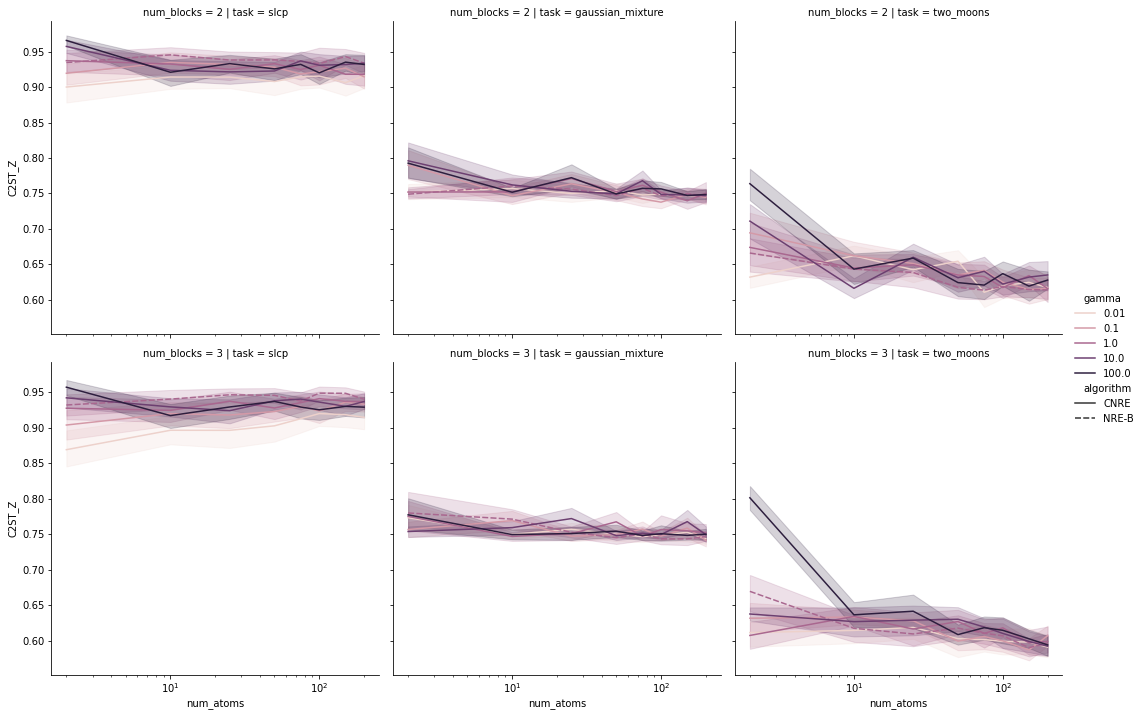

In [6]:
fg = sns.relplot(
    data=prepare_gamma_for_plot(df_wide),
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

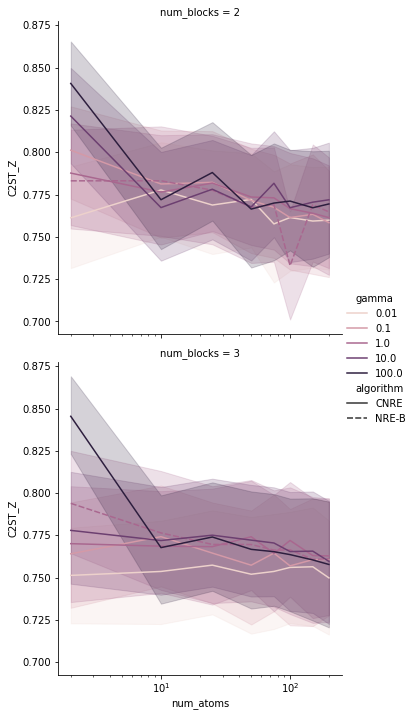

In [7]:
fg = sns.relplot(
    data=prepare_gamma_for_plot(df_wide),
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    # col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

## what do we expect for experiments

In [ ]:
columns = ['task', 'num_observation', 'algorithm', 'num_atoms', 'gamma', 'num_blocks']

# general for nre
# tasks = sbibm.get_available_tasks()
tasks = ['slcp', 'two_moons', 'gaussian_mixture']
num_observation = list(range(1,11))
num_atoms = [2, 10, 25, 50, 75, 100, 150, 200]
num_blocks = [2, 3]

# for cnre
gammas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [ ]:
experiments_cnre = list(product(tasks, num_observation, ['CNRE'], num_atoms, gammas, num_blocks))
df_cnre = pd.DataFrame(data=experiments_cnre, columns=columns)

experiments_nre = list(product(tasks, num_observation, ['NRE-B'], num_atoms, [nre_gamma_default], num_blocks))
df_nre = pd.DataFrame(data=experiments_nre, columns=columns)

df_ref = pd.concat([df_cnre, df_nre])
print(len(df_ref))
df_ref

NameError: name 'product' is not defined

## what's missing?

In [ ]:
def get_missing_experiments(expr: pd.DataFrame, ref: pd.DataFrame = df_ref) -> pd.DataFrame:
    merge_df = ref.merge(expr, how='left', indicator=True)
    merge_df = merge_df[merge_df['_merge'] == 'left_only']
    return merge_df.drop("_merge", axis=1)

In [ ]:
df_wide_counts = df_wide.groupby(columns, as_index=False).size()
print(df_wide_counts["size"].unique())
df_wide_counts

[2]


,task,num_observation,algorithm,num_atoms,gamma,num_blocks,size
0,gaussian_mixture,1,CNRE,2,0.01,2,2
1,gaussian_mixture,1,CNRE,2,0.01,3,2
2,gaussian_mixture,1,CNRE,2,0.10,2,2
3,gaussian_mixture,1,CNRE,2,0.10,3,2
4,gaussian_mixture,1,CNRE,2,1.00,2,2
...,...,...,...,...,...,...,...
2875,two_moons,10,NRE-B,100,inf,3,2
2876,two_moons,10,NRE-B,150,inf,2,2
2877,two_moons,10,NRE-B,150,inf,3,2
2878,two_moons,10,NRE-B,200,inf,2,2


In [ ]:
df_wide_counts[df_wide_counts["size"] == 1]

,task,num_observation,algorithm,num_atoms,gamma,num_blocks,size


In [ ]:
df_to_check = df_wide.reset_index()[columns].drop_duplicates()
get_missing_experiments(df_to_check)

,task,num_observation,algorithm,num_atoms,gamma,num_blocks
